In [1]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.metrics import mean_iou
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


Defining a function to sort the image filenames so we can load images in order.

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

### Loading the Data

We use our defined method as a key to load images in order

In [3]:
filelist_trainx = sorted(glob.glob('trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('trainy/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = sorted(glob.glob('testx/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = sorted(glob.glob('testy/*.jpg'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

filelist_valx = sorted(glob.glob('validationx/*.jpg'), key=numericalSort)
X_val = np.array([np.array(Image.open(fname)) for fname in filelist_valx])

filelist_valy = sorted(glob.glob('validationy/*.jpg'), key=numericalSort)
Y_val = np.array([np.array(Image.open(fname)) for fname in filelist_valy])

Let us see some of the images and their ground truths

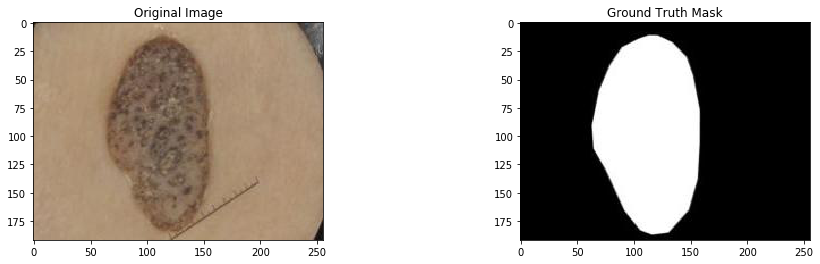

In [4]:
img_num = 112
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(X_test[img_num])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth Mask')
plt.show()

### Defining the Loss Function

In [5]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

### Evaluation metric for Image Segmentation

In [6]:

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

### The Model

Augmenting the images for better performance on poor contrast images

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [9]:
(x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

def model_seg():

    # Convolution Layers (BatchNorm after non-linear activation)

    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn9')(x)
    
    x = Dropout(0.5)(x) # not original

    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)

    model = Model(inputs=img_input, outputs=pred)
    model.summary()
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
    
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=18),
                              epochs = 1,steps_per_epoch=x_train.shape[0] // 18, validation_data = (x_test, y_test),
                              verbose = 1)

    #hist = model.fit(x_train, y_train, epochs= 1, batch_size= 16,validation_data=(x_test, y_test), verbose=1)
    #model.save("model_exact_augmented_epoch_200.h5")

    accuracy = model.evaluate(x=x_test,y=y_test,batch_size=18)
    print("Accuracy: ",accuracy[1])

In [11]:
model_seg()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 16)      1216      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 32)      4640      
_________________________________________________________________
bn2 (BatchNormalizati

ResourceExhaustedError: OOM when allocating tensor with shape[18,48,64,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node activation_5/Relu-1-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


------------------------------

In [113]:
img_input = Input(shape= (192, 256, 3))
x = Conv2D(16, (5, 5), padding='same', name='conv1')(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)

# Deconvolution Layers (BatchNorm after non-linear activation)

x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn18')(x)

x = Dropout(0.5)(x) # not original

x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)


In [114]:

model_2 = Model(inputs=img_input, outputs=pred)
model_2.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])


In [115]:
model_2.load_weights('model_exact_augmented_epoch_200.h5')

In [116]:
model_2.save_weights('model_exact_augmented_epoch_200.h5')

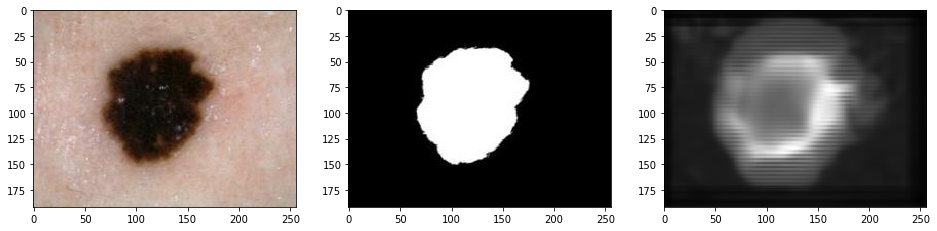

In [117]:
img_num = 280
img_pred = model_2.predict(X_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()

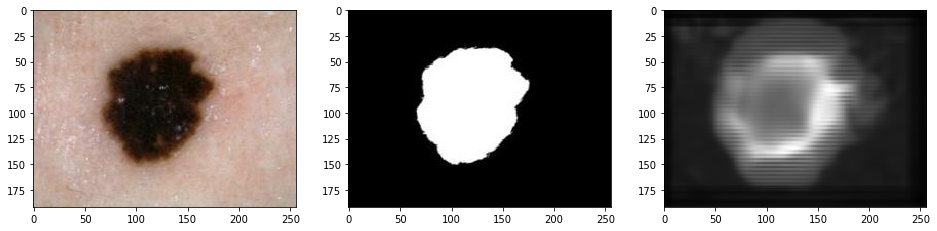

In [118]:
img_num = 280
img_pred = model_2.predict(X_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()

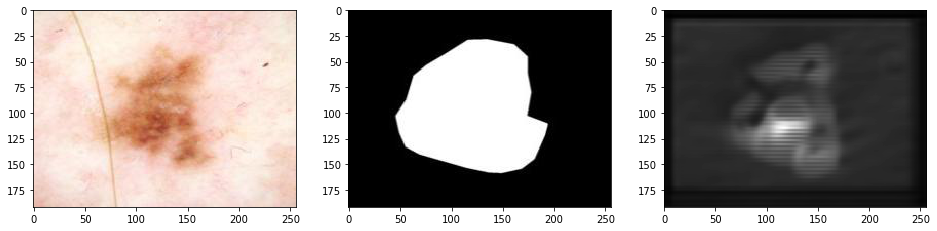

In [126]:
img_num = 1789
img_pred = model_2.predict(X_train[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_train[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_train[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()

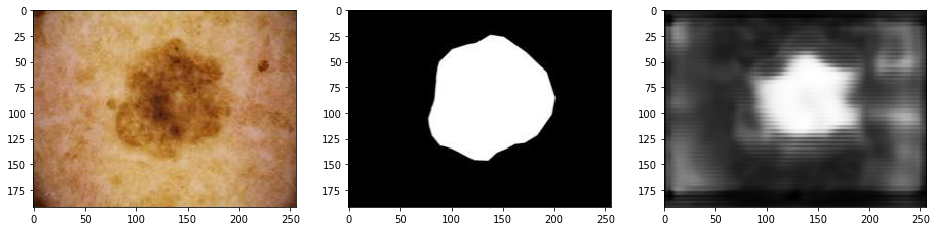

In [120]:
img_num = 114
img_pred = model_2.predict(X_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()

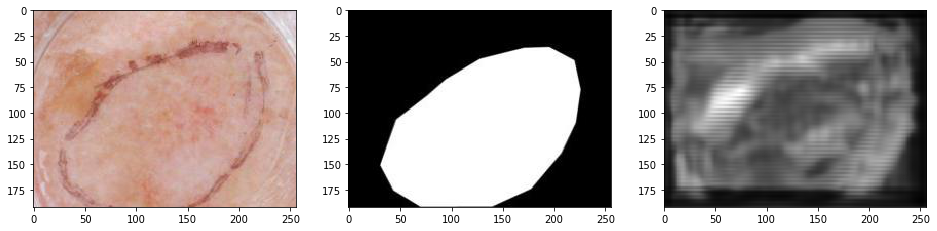

In [121]:
img_num = 444
img_pred = model_2.predict(X_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()